In [14]:
import numpy as np
import os
import service.train as ts
import service.data as ds

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
# define base data, label store path
base_data_path = ds.old_data_path

In [16]:
with open(f'{base_data_path}/labels.txt', 'r') as f:
    lines = f.readlines()
    actions = [line.strip().split()[0] for line in lines]
    labels = [line.strip().split()[1] for line in lines]

# 라벨 추가 작업 수행
gesture_data = []
for action, label in zip(actions, labels):
    seq_data = np.load(f'{base_data_path}/seq_{action}.npy')
    label_data = np.full((seq_data.shape[0], seq_data.shape[1], 1), label) # 라벨 추가
    data_with_label = np.concatenate([seq_data, label_data], axis=-1) # 라벨 추가된 데이터
    gesture_data.append(data_with_label)

data = np.concatenate(gesture_data, axis=0)
data.shape

(2835, 30, 78)

In [17]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

x_data.shape, labels.shape

((2835, 30, 77), (2835,))

In [18]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2835, 5)

In [19]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2022)

x_train.shape, y_train.shape

((2551, 30, 77), (2551, 5))

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.regularizers import l2

model = Sequential([
    GRU(64, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(32, activation='tanh'),
    Dense(8, activation='tanh'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                27456     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 5)                 45        
                                                                 
Total params: 29,845
Trainable params: 29,845
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the callbacks
callbacks = [
    ModelCheckpoint('models/base_model1.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=30, verbose=1, mode='auto'),
]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/200
16/20 [=======================>......] - ETA: 0s - loss: 1.3312 - acc: 0.4404
Epoch 1: val_acc improved from -inf to 0.88732, saving model to models\base_model1.h5
20/20 [==============================] - 2s 27ms/step - loss: 1.2632 - acc: 0.4853 - val_loss: 0.8395 - val_acc: 0.8873 - lr: 0.0010
Epoch 2/200
17/20 [========================>.....] - ETA: 0s - loss: 0.8666 - acc: 0.7178
Epoch 2: val_acc improved from 0.88732 to 0.93310, saving model to models\base_model1.h5
20/20 [==============================] - 0s 13ms/step - loss: 0.8493 - acc: 0.7272 - val_loss: 0.5986 - val_acc: 0.9331 - lr: 0.0010
Epoch 3/200
16/20 [=======================>......] - ETA: 0s - loss: 0.7002 - acc: 0.8071
Epoch 3: val_acc improved from 0.93310 to 0.97887, saving model to models\base_model1.h5
20/20 [==============================] - 0s 13ms/step - loss: 0.6880 - acc: 0.8126 - val_loss: 0.4657 - val_acc: 0.9789 - lr: 0.0010
Epoch 4/200
17/20 [========================>.....] - ETA: 0s - loss

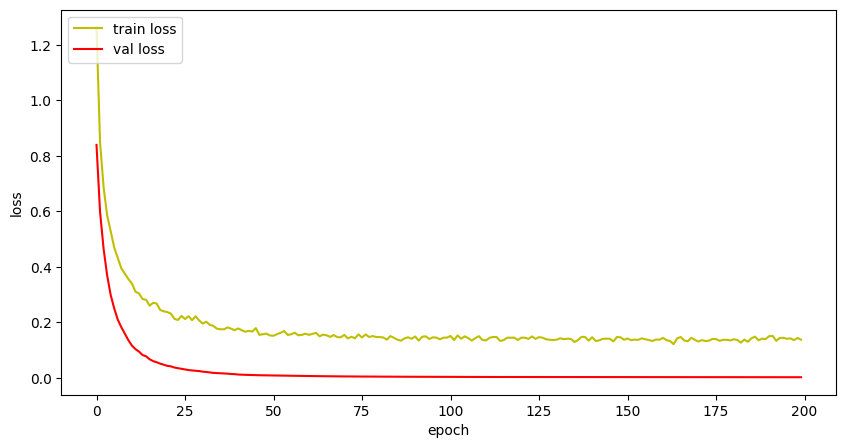

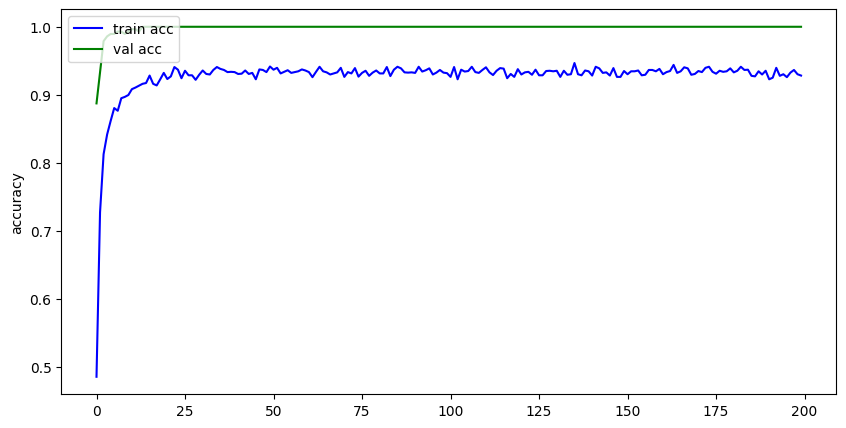

In [24]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10, 5))

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

fig, acc_ax = plt.subplots(figsize=(10, 5))
acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()